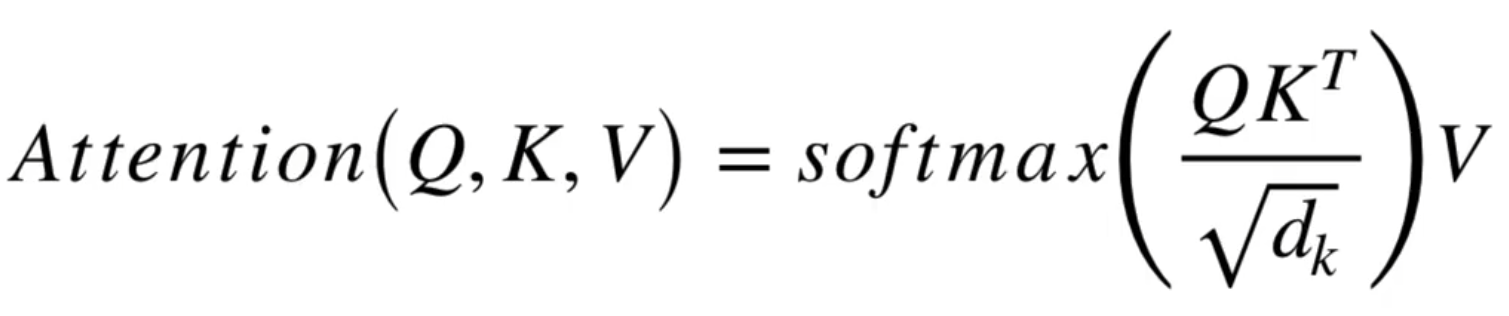

In [43]:
from IPython.display import Image
Image(filename='qkv.png')
# 公式中V前面的整个部分就称为Attention scores

In [ ]:
import torch
from torch import nn
import math
from bertviz.transformers_neuron_view import BertModel, BertConfig
from transformers import BertTokenizer

## 1. model config and load

In [ ]:
max_length = 256
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_name, output_attentions=True, 
                                    output_hidden_states=True, 
                                    return_dict=True)
tokenizer = BertTokenizer.from_pretrained(model_name)
config.max_position_embeddings = max_length

model = BertModel(config).from_pretrained(model_name)
model = model.eval()

In [ ]:
model.config

In [ ]:
# Attention中每个头的维度
att_head_size = int(model.config.hidden_size/model.config.num_attention_heads)

In [ ]:
att_head_size

In [ ]:
# bert的encoder架构,layer的结构可以进行索引,并且还可以继续向下索引
model.encoder
# model.encoder.layer[0].attention

In [ ]:
model.encoder.layer[0].attention.self.query.weight.T[:, 64:128]

## 2. data

In [ ]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
inputs_tests = tokenizer(newsgroups_train['data'][:1], 
                         truncation=True, padding=True, max_length=max_length, 
                         return_tensors='pt')

In [ ]:
inputs_tests

In [ ]:
inputs_tests['input_ids'].shape

In [ ]:
inputs_tests.keys()

## 3. model output

In [ ]:
model_output = model(**inputs_tests)
# 模型的输出包括下面四个部分

- last_hidden_state (batch_size, sequence_length, hidden_size) : last hidden state which is outputted from the last BertLayer
- pooler_output (batch_size, hidden_size) : output of the Pooler layer
- hidden_states (batch_size, sequence_length, hidden_size): hidden-states of the model at the output of each BertLayer plus the initial embedding
- attentions (batch_size, num_heads, sequence_length, sequence_length): one for each BertLayer. Attentions weights after the attention SoftMax

In [ ]:
len(model_output)

In [ ]:
model_output[1]

In [ ]:
model_output[-1][0]['attn'][0, 0, :, :]

## 4. from scratch

手动复现bert encoder中的self attention 的过程

In [40]:
emb_output = model.embeddings(inputs_tests['input_ids'], inputs_tests['token_type_ids'])

In [41]:
emb_output.shape

torch.Size([1, 201, 768])

In [42]:
model.encoder.layer[0]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [ ]:
# emb_output[0].shape: 201*768
# query.weight.T.shape: 768*768, query.weight.T[:, :att_head_size]: 768*64
# 201*64
Q_first_head_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.query.weight.T[:, :att_head_size] \
                            + model.encoder.layer[0].attention.self.query.bias[:att_head_size]

In [ ]:
# 201*64
K_first_head_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.key.weight.T[:, :att_head_size] \
                            + model.encoder.layer[0].attention.self.key.bias[:att_head_size]

In [ ]:
# (201*64)*(64*201) ==> 201*201
attn_scores = torch.nn.Softmax(dim=-1)(Q_first_head_first_layer @ K_first_head_first_layer.T / math.sqrt(att_head_size))

In [ ]:
attn_scores

In [ ]:
attn_scores.sum(dim=-1)

In [ ]:
V_first_head_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.value.weight.T[:, :att_head_size] \
                            + model.encoder.layer[0].attention.self.value.bias[:att_head_size]

In [ ]:
attn_emb = attn_scores @ V_first_head_first_layer

In [ ]:
attn_emb.shape

In [ ]:
V_first_head_first_layer

### 5. all

In [ ]:
Q_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.query.weight.T \
                            + model.encoder.layer[0].attention.self.query.bias
K_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.key.weight.T \
                            + model.encoder.layer[0].attention.self.key.bias
V_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.value.weight.T \
                            + model.encoder.layer[0].attention.self.value.bias

In [ ]:
scores = torch.nn.Softmax(dim=-1)(Q_first_layer @ K_first_layer.T / math.sqrt(64))

In [ ]:
scores @ V_first_layer[:, :64]